In [118]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

class LJParticles:
    def __init__(self, N=64, L=10.0, temperature=1.0, dt=0.01):
        # Initialize system parameters
        self.N = N
        self.L = L  # Square box (L×L)
        self.dt = dt
        self.initial_temperature = temperature

        # Arrays for positions, velocities, and accelerations
        self.x = np.zeros(N)
        self.y = np.zeros(N)
        self.vx = np.zeros(N)
        self.vy = np.zeros(N)
        self.ax = np.zeros(N)
        self.ay = np.zeros(N)

        # Tracking
        self.time = 0.0
        self.potential_energy = 0.0
        self.kinetic_energy = 0.0
        self.total_energy = 0.0

        # Initialize particles on a square lattice with 8×8 grid
        self.set_square_lattice()

        # Initialize velocities to get the desired temperature
        self.set_velocities()

        # Calculate initial accelerations and energy
        self.compute_acceleration()
        self.compute_energy()

    def set_square_lattice(self):
        """Place particles on a square lattice"""
        nx = int(np.sqrt(self.N))  # 8 particles per row
        ny = nx  # 8 particles per column

        # Calculate spacing between particles
        dx = self.L / nx
        dy = self.L / ny

        # Place particles
        count = 0
        for ix in range(nx):
            for iy in range(ny):
                if count < self.N:
                    self.x[count] = dx * (ix + 0.5)  # Center in the cell
                    self.y[count] = dy * (iy + 0.5)
                    count += 1

    def set_velocities(self):
        """Set random velocities with zero center-of-mass momentum"""
        # Generate random velocities
        self.vx = np.random.randn(self.N) - 0.5
        self.vy = np.random.randn(self.N) - 0.5

        # Set center-of-mass momentum to zero
        self.vx -= np.mean(self.vx)
        self.vy -= np.mean(self.vy)

        # Calculate current kinetic energy
        current_ke = 0.5 * np.sum(self.vx**2 + self.vy**2) / self.N

        # Scale velocities to match desired temperature
        scale_factor = np.sqrt(self.initial_temperature / current_ke)
        self.vx *= scale_factor
        self.vy *= scale_factor

    def pbc_separation(self, dr, L):
        """Apply minimum image convention for distance"""
        if dr > 0.5 * L:
            return dr - L
        elif dr < -0.5 * L:
            return dr + L
        return dr

    def pbc_position(self, r, L):
        """Apply periodic boundary conditions to position"""
        return r % L

    def compute_acceleration(self):
        """Calculate forces and accelerations using Lennard-Jones potential"""
        # Reset accelerations and potential energy
        self.ax = np.zeros(self.N)
        self.ay = np.zeros(self.N)
        self.potential_energy = 0.0
        self.virial = 0.0

        # Loop over all pairs of particles
        for i in range(self.N - 1):
            for j in range(i + 1, self.N):
                # Calculate separation with periodic boundary conditions
                dx = self.pbc_separation(self.x[i] - self.x[j], self.L)
                dy = self.pbc_separation(self.y[i] - self.y[j], self.L)

                # Square distance
                r2 = dx**2 + dy**2

                # Compute Lennard-Jones force and potential
                if r2 > 0:  # Avoid division by zero
                    r2i = 1.0 / r2
                    r6i = r2i**3
                    f_mag= 48.0 * r2i * r6i * (r6i - 0.5) # same as: f_mag = 24.0 * r2i * r6i * (2 * r6i - 1)

                    # Update accelerations
                    self.ax[i] += f_mag * dx
                    self.ay[i] += f_mag * dy
                    self.ax[j] -= f_mag * dx
                    self.ay[j] -= f_mag * dy

                    # Update potential energy
                    self.potential_energy += 4.0 * r6i * (r6i - 1.0)

                    # Update virial (pressure term)
                    self.virial += f_mag * (dx*dx + dy*dy)

    def compute_energy(self):
        """Calculate the kinetic energy and total energy"""
        # KE = (1/2)mv²
        # v² = vx² + vy² (the squared velocity is the sum of squared components)
        self.kinetic_energy = 0.5 * np.sum(self.vx**2 + self.vy**2)
        self.total_energy = self.kinetic_energy + self.potential_energy

    def get_temperature(self):
        """Calculate the current temperature based on equation (8.5)"""
        # For 2D system with N particles
        return np.sum(self.vx**2 + self.vy**2) / (2 * self.N)

    def compute_pressure(self):
        T = self.get_temperature()
        V = self.L ** 2
        self.pressure = (self.N * T + 0.5 * self.virial) / V

    def step(self):
        """Perform one time step using the Velocity Verlet algorithm"""
        # First half of velocity update
        self.vx += 0.5 * self.dt * self.ax
        self.vy += 0.5 * self.dt * self.ay

        # Update positions
        self.x += self.dt * self.vx
        self.y += self.dt * self.vy

        # Apply periodic boundary conditions
        for i in range(self.N):
            self.x[i] = self.pbc_position(self.x[i], self.L)
            self.y[i] = self.pbc_position(self.y[i], self.L)

        # Calculate new accelerations
        self.compute_acceleration()

        # Second half of velocity update
        self.vx += 0.5 * self.dt * self.ax
        self.vy += 0.5 * self.dt * self.ay

        # Update energy and time
        self.compute_energy()
        self.compute_pressure()
        self.time += self.dt

    def remove_drift(self):
        """Remove net momentum by adjusting velocities to keep total linear momentum zero."""
        # Total momentum in x and y
        px = np.sum(self.vx)
        py = np.sum(self.vy)

        # Subtract average momentum per particle from each velocity
        self.vx -= px / self.N
        self.vy -= py / self.N


# Create the simulation
sim = LJParticles(N=64, L=10.0, temperature=1.0, dt=0.01)

# Run simulation and record positions
num_steps = 500
positions_history = []
energy_values = []
temp_values = []

# Save initial positions
positions_history.append((sim.x.copy(), sim.y.copy()))

# Save initial energy
energy_values.append(sim.total_energy - sim.potential_energy)

# Run the simulation
for i in range(num_steps):
    sim.step()
    energy_values.append(sim.total_energy - sim.potential_energy)
    temp_values.append(sim.get_temperature())

    # Save positions every few steps to make the animation smoother
    if i % 5 == 0:
        positions_history.append((sim.x.copy(), sim.y.copy()))

# Create animation
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, sim.L)
ax.set_ylim(0, sim.L)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Lennard-Jones Particles Simulation (N=64, L=10)')
ax.grid(True)

# Draw boundary box
ax.plot([0, sim.L, sim.L, 0, 0], [0, 0, sim.L, sim.L, 0], 'k-')
plt.close()

# Create scatter plot for particles
particles = ax.scatter([], [], s=30)

# Animation function
def init():
    particles.set_offsets(np.c_[[], []])
    return [particles]

def animate(i):
    x, y = positions_history[i]
    particles.set_offsets(np.c_[x, y])
    return [particles]

# Create animation
anim = FuncAnimation(
    fig, animate, init_func=init,
    frames=len(positions_history), interval=50, blit=True
)

# Display animation
HTML(anim.to_jshtml())

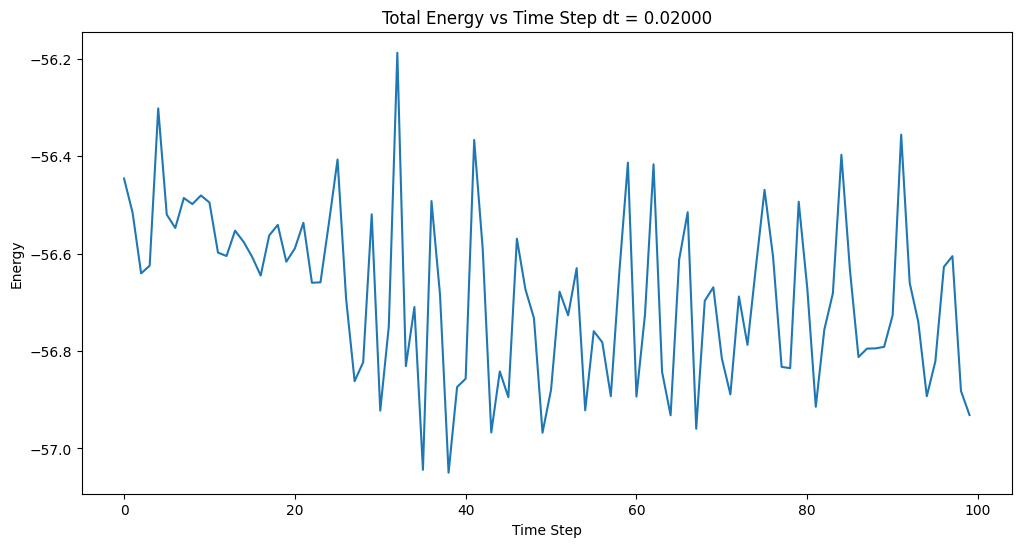

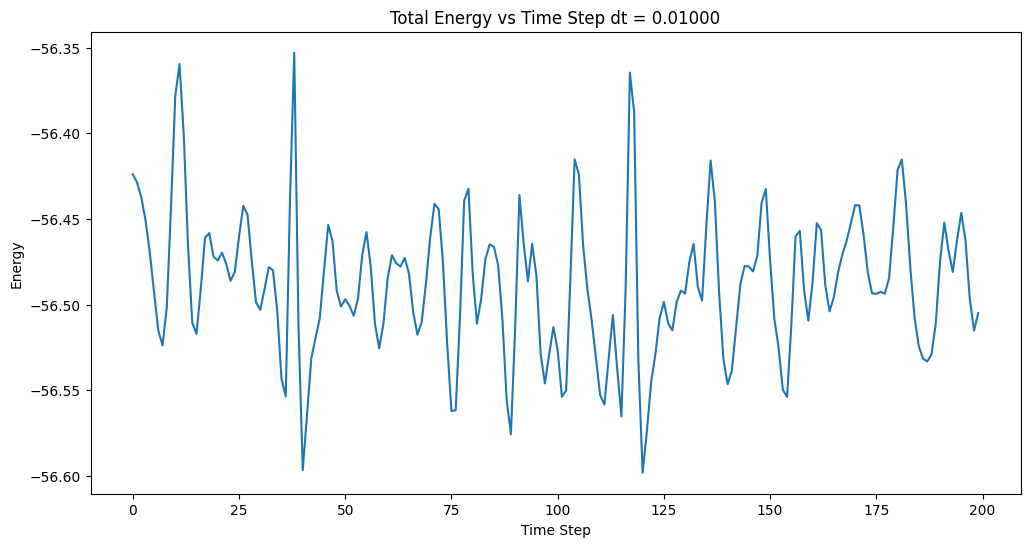

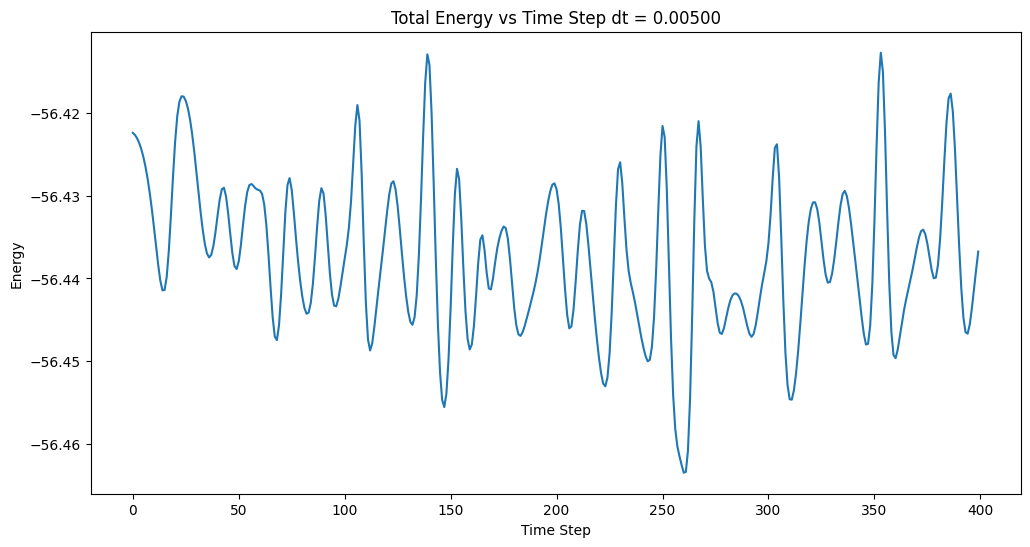

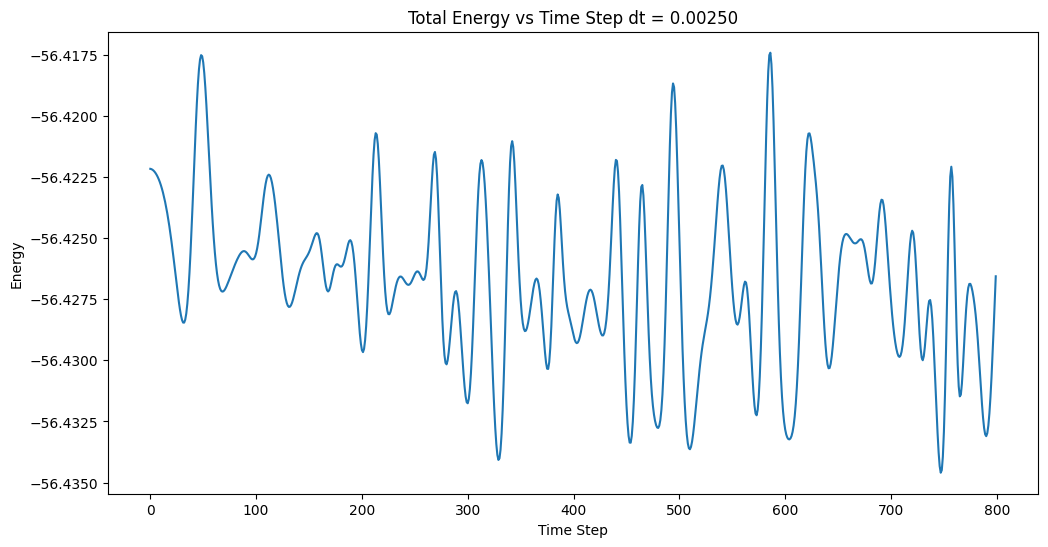

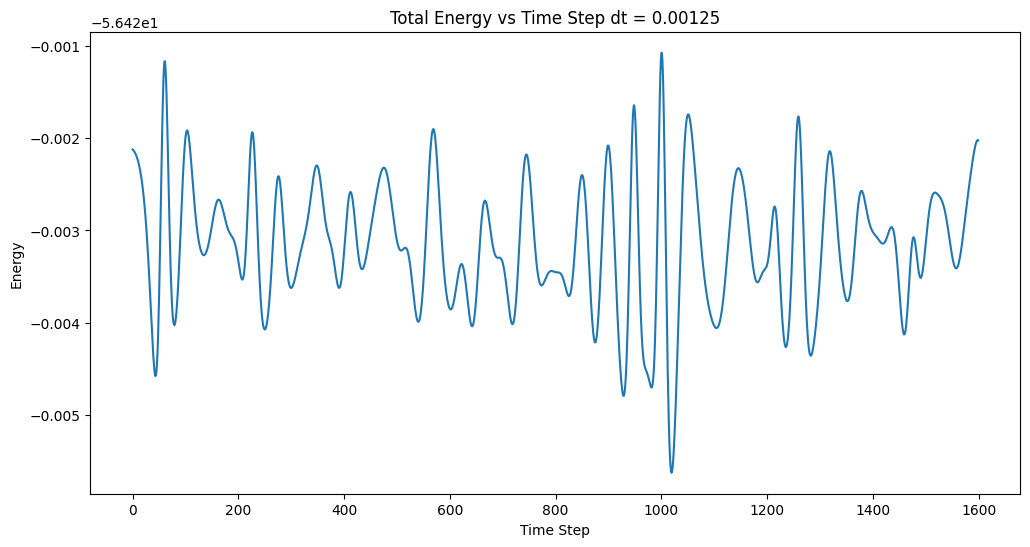

In [ ]:
dts = [0.02, 0.01, 0.005, 0.0025, 0.00125]
total_time = 2.0

for dt in dts:
    # Create the simulation
    sim = LJParticles(N=64, L=10.0, temperature=1.0, dt=dt)

    # Run simulation and record positions
    num_steps = int(total_time / dt)
    positions_history = []
    energy_values = []
    energy_errors = []
    temp_values = []

    # Save initial positions
    positions_history.append((sim.x.copy(), sim.y.copy()))

    # Run the simulation
    for i in range(num_steps):
        sim.step()
        energy_values.append(sim.total_energy)
        energy_errors.append(np.abs(sim.total_energy - initial_energy))
        temp_values.append(sim.get_temperature())
        positions_history.append((sim.x.copy(), sim.y.copy()))

    # Plot energy
    plt.figure(figsize=(12, 6))
    plt.plot(energy_values, label='Total Energy')
    plt.xlabel('Time Step')
    plt.ylabel('Energy')
    plt.title('Total Energy vs Time Step dt = {:.5f}'.format(dt))

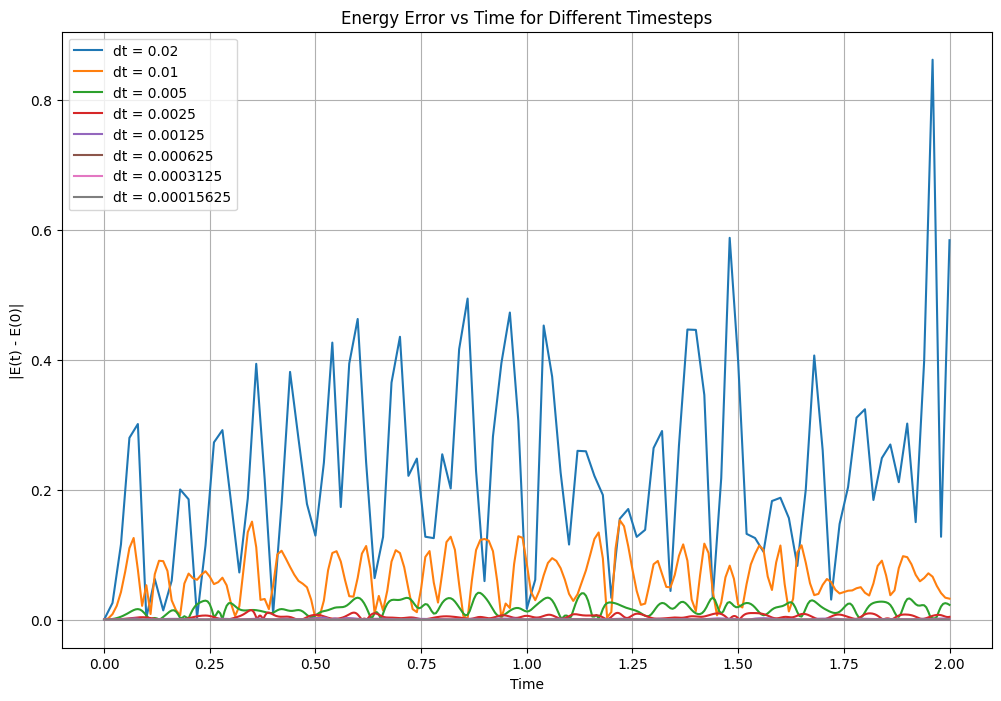

In [ ]:
# Problem 8.5 (a) – Total energy conservation

# dts = [0.02, 0.01, 0.005, 0.0025, 0.00125]
dts = [0.02, 0.01, 0.005, 0.0025, 0.00125, 0.000625, 0.0003125, 0.00015625]
total_time = 2.0
results = {}

plt.figure(figsize=(12, 8))

for dt in dts:
    # Create the simulation
    sim = LJParticles(N=64, L=10.0, temperature=1.0, dt=dt)

    # Run simulation
    num_steps = int(total_time / dt)

    # Save initial energy
    initial_energy = sim.total_energy

    # Arrays to track data
    time_points = [0]
    energy_values = [initial_energy]
    energy_errors = [0]  # Start with zero error
    max_error = 0

    # Run the simulation
    for i in range(num_steps):
        sim.step()

        # Calculate current time
        current_time = (i+1) * dt
        time_points.append(current_time)

        # Record energy
        energy_values.append(sim.total_energy)

        # Calculate and record energy error
        current_error = abs(sim.total_energy - initial_energy)
        energy_errors.append(current_error)

        # Update maximum error
        if current_error > max_error:
            max_error = current_error

    # Store the maximum error for this timestep
    results[dt] = max_error

    # Plot energy error for this timestep
    plt.plot(time_points, energy_errors, label=f'dt = {dt}')

# Finish energy error plot
plt.xlabel('Time')
plt.ylabel('|E(t) - E(0)|')
plt.title('Energy Error vs Time for Different Timesteps')
plt.legend()
plt.grid(True)
plt.show()


# # Calculate and display the order of convergence
# ratios = []
# for i in range(len(dt_values)-1):
#     dt_ratio = dt_values[i] / dt_values[i+1]
#     error_ratio = error_values[i] / error_values[i+1]
#     order = np.log(error_ratio) / np.log(dt_ratio)
#     ratios.append(order)

#     print(f"Timestep reduction: {dt_values[i]} → {dt_values[i+1]}")
#     print(f"Error reduction: {error_values[i]:.6e} → {error_values[i+1]:.6e}")
#     print(f"Ratio: {error_ratio:.4f}")
#     print(f"Order of convergence: {order:.4f} (Expected: 2.0 for Verlet)")
#     print()

+---------------+------------------------+
| Timestep (dt) |  Maximum Energy Error  |
+---------------+------------------------+
|      0.02     |   0.862432080279838    |
|      0.01     |  0.15324470220370756   |
|     0.005     |  0.04153363255471021   |
|     0.0025    |  0.014756672728573506  |
|    0.00125    | 0.0032440935463853293  |
|    0.000625   | 0.0006591736638554835  |
|   0.0003125   | 0.00024182633330838144 |
|   0.00015625  | 4.974455107742415e-05  |
+---------------+------------------------+
Slope of the line: 2.0


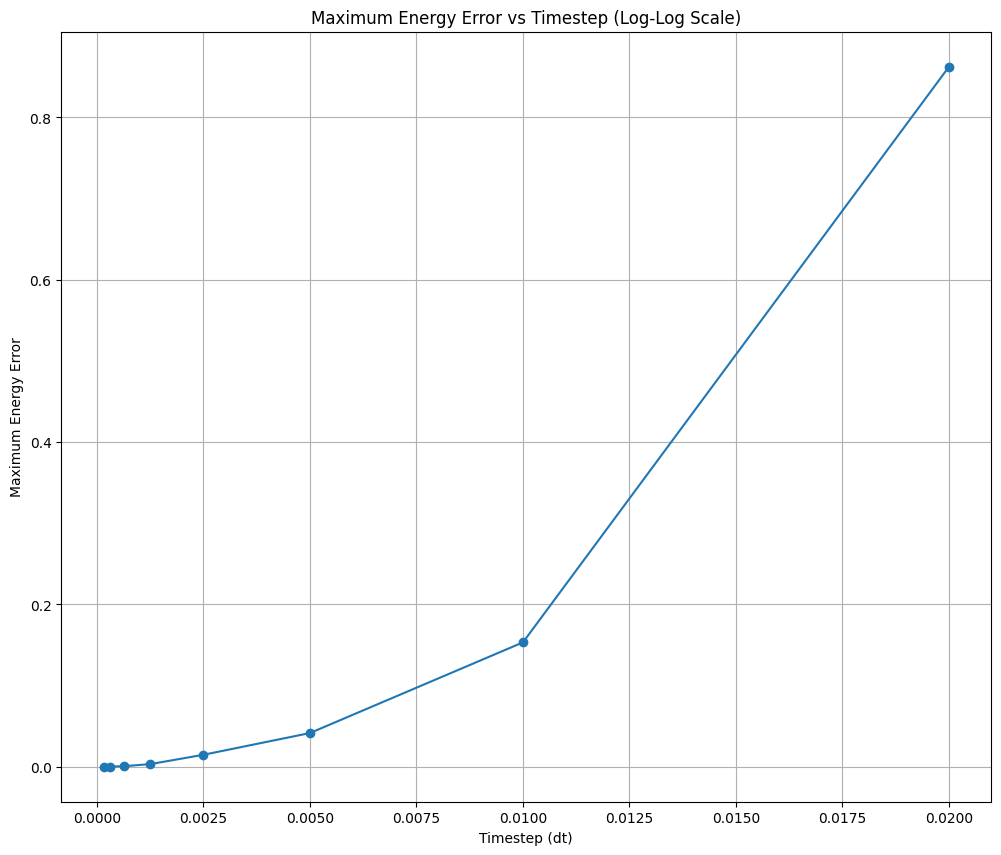

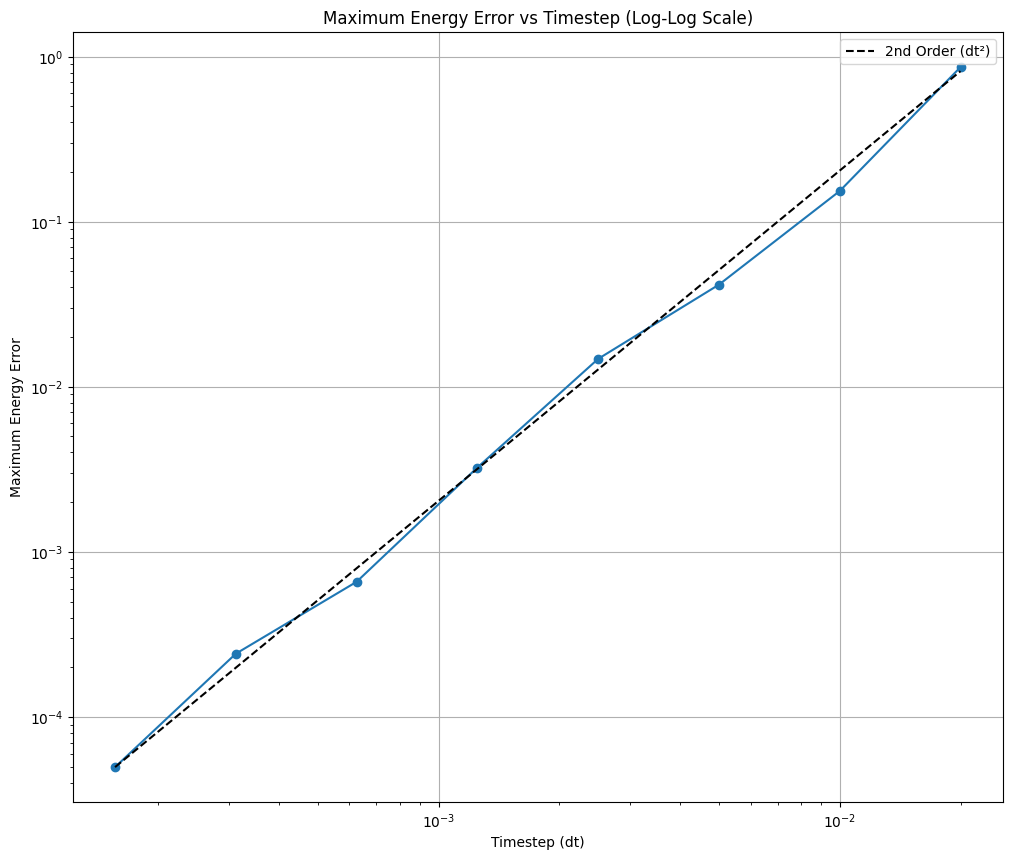

In [ ]:
from prettytable import PrettyTable

dt_values = list(results.keys())
error_values = [results[dt] for dt in dt_values]

# Create a PrettyTable instance
error_table = PrettyTable()
error_table.field_names = ["Timestep (dt)", "Maximum Energy Error"]

# Add rows to the table
for dt, error in zip(dt_values, error_values):
    error_table.add_row([dt, error])

# Print the table
print(error_table)

plt.figure(figsize=(12, 10))
plt.plot(dt_values, error_values, 'o-')
plt.xlabel('Timestep (dt)')
plt.ylabel('Maximum Energy Error')
plt.title('Maximum Energy Error vs Timestep (Log-Log Scale)')
plt.grid(True)

# Add a reference line for second-order convergence
ref_x = np.array([min(dt_values), max(dt_values)])
ref_y = error_values[-1] * (ref_x / dt_values[-1])**2  # divides each element in ref_x by the smallest dt → this gives a length-2 array.
# print(ref_x, ref_y)
# slope = np.log(ref_y[1] / ref_y[0]) / np.log(ref_x[1] / ref_x[0])
# print(f"Slope of the line: {slope}")

plt.figure(figsize=(12, 10))
plt.loglog(dt_values, error_values, 'o-')
plt.loglog(ref_x, ref_y, 'k--', label='2nd Order (dt²)')
plt.xlabel('Timestep (dt)')
plt.ylabel('Maximum Energy Error')
plt.title('Maximum Energy Error vs Timestep (Log-Log Scale)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Problem 8.5 (b) – Drift and noise
# log(∆E) = log(∆T ^ a)
# log(∆E) = a * log(∆T)
# a ≈ 2


dts = [0.02, 0.01, 0.005, 0.0025, 0.00125]
# dts = [0.02, 0.01, 0.005, 0.0025, 0.00125, 0.000625, 0.0003125, 0.00015625]
total_time = 2.0
results = {}

# Arrays to store drift and noise values
drift_values = []
noise_values = []

for dt in dts:
    # Create the simulation
    sim = LJParticles(N=64, L=10.0, temperature=1.0, dt=dt)

    # Run simulation
    num_steps = int(total_time / dt)

    # Compute initial energy
    sim.compute_acceleration()
    sim.compute_energy()
    initial_energy = sim.total_energy

    # Arrays to track data
    time_points = [0]
    energy_values = [initial_energy]
    energy_errors = [0]  # Start with zero error
    max_error = 0

    # Run the simulation
    for i in range(num_steps):
        sim.step()

        # Calculate current time
        current_time = (i+1) * dt
        time_points.append(current_time)

        # Record energy
        energy_values.append(sim.total_energy)

        # Calculate and record energy error
        current_error = abs(sim.total_energy - initial_energy)
        energy_errors.append(current_error)

        # Update maximum error
        if current_error > max_error:
            max_error = current_error

    # Store the maximum error for this timestep
    results[dt] = max_error

    # Perform linear regression
    energy_values = np.array(energy_values)
    time_points = np.array(time_points)
    slope, intercept, r_value, p_value, std_err = stats.linregress(time_points, energy_values)

    # Calculate fitted line
    fit_line = slope * time_points + intercept

    # Calculate deviations from the fit line
    deviations_from_fit_line = energy_values - fit_line

    # Calculate root mean square deviation (noise)
    rms_deviation = np.sqrt(np.mean(deviations_from_fit_line**2))

    # Store the drift and noise values
    drift_values.append(abs(slope))
    noise_values.append(rms_deviation)

    # print(drift_values)
    # print(noise_values)

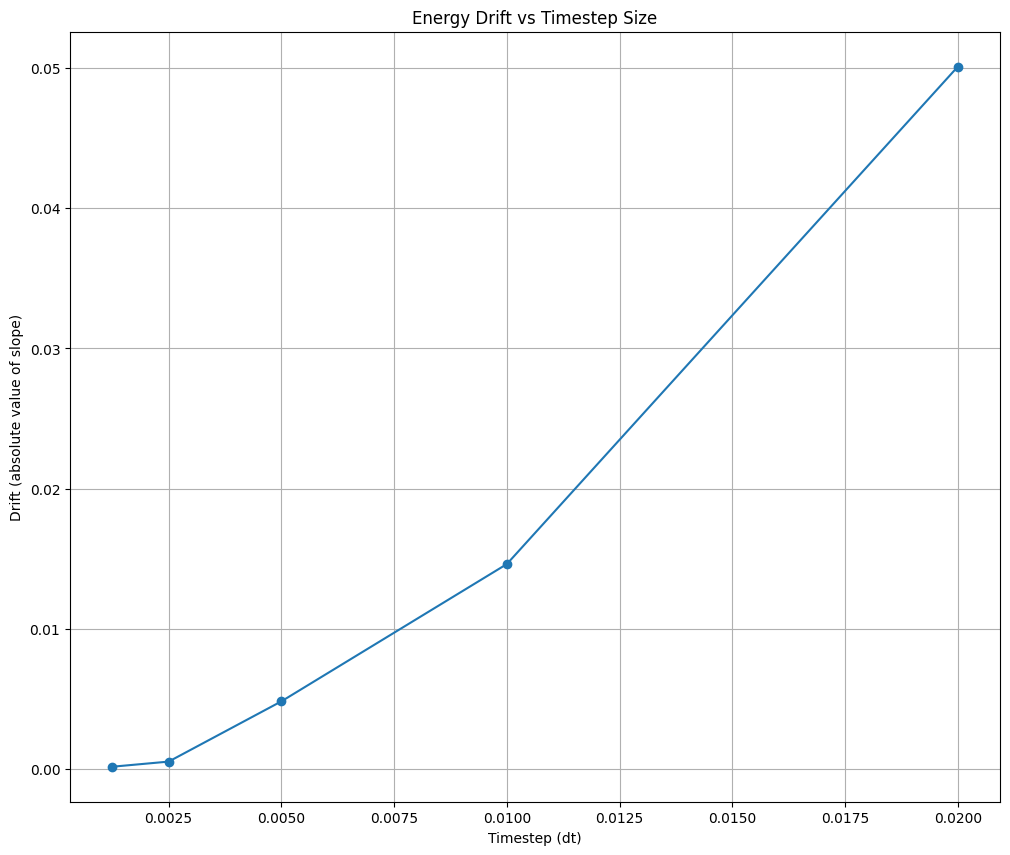

In [131]:
# Plot drift vs timestep
plt.figure(figsize=(12, 10))
plt.plot(dts, drift_values, 'o-')
# plt.loglog(dts, drift_values, 'o-')
plt.xlabel('Timestep (dt)')
plt.ylabel('Drift (absolute value of slope)')
plt.title('Energy Drift vs Timestep Size')
plt.grid(True)
plt.show()

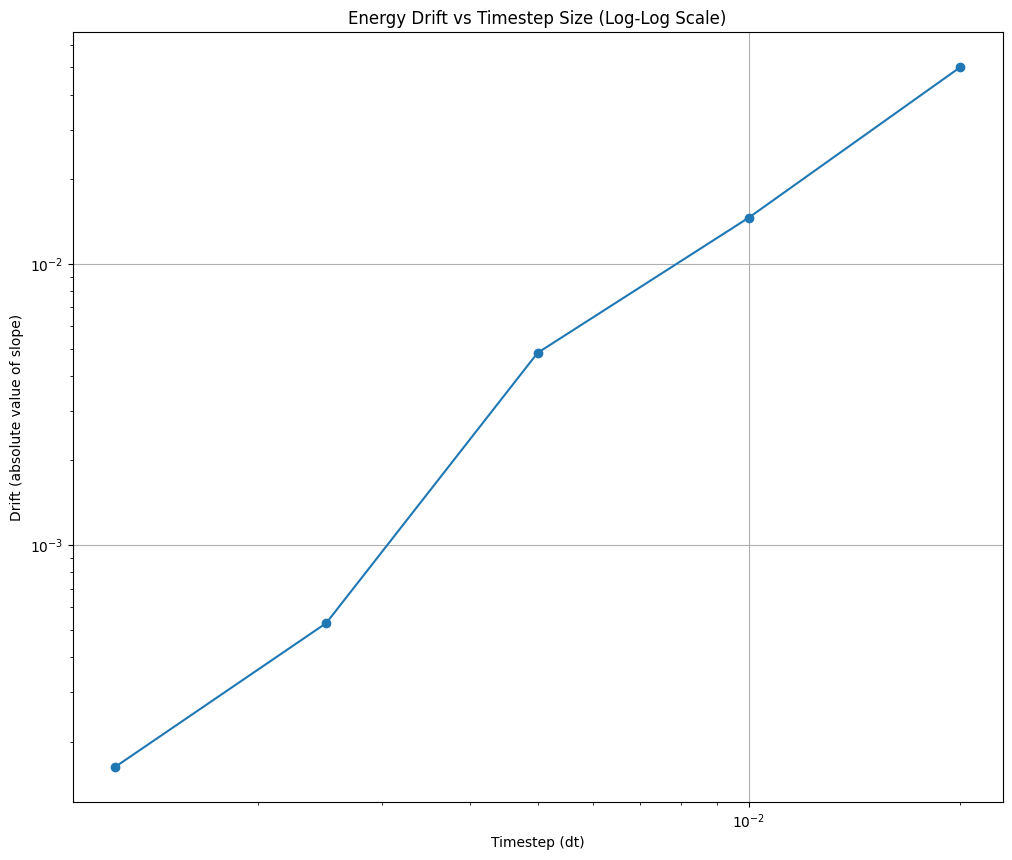

In [132]:
# Plot drift vs timestep (log-log scale)
plt.figure(figsize=(12, 10))
# plt.plot(dts, drift_values, 'o-')
plt.loglog(dts, drift_values, 'o-')
plt.xlabel('Timestep (dt)')
plt.ylabel('Drift (absolute value of slope)')
plt.title('Energy Drift vs Timestep Size (Log-Log Scale)')
plt.grid(True)
plt.show()

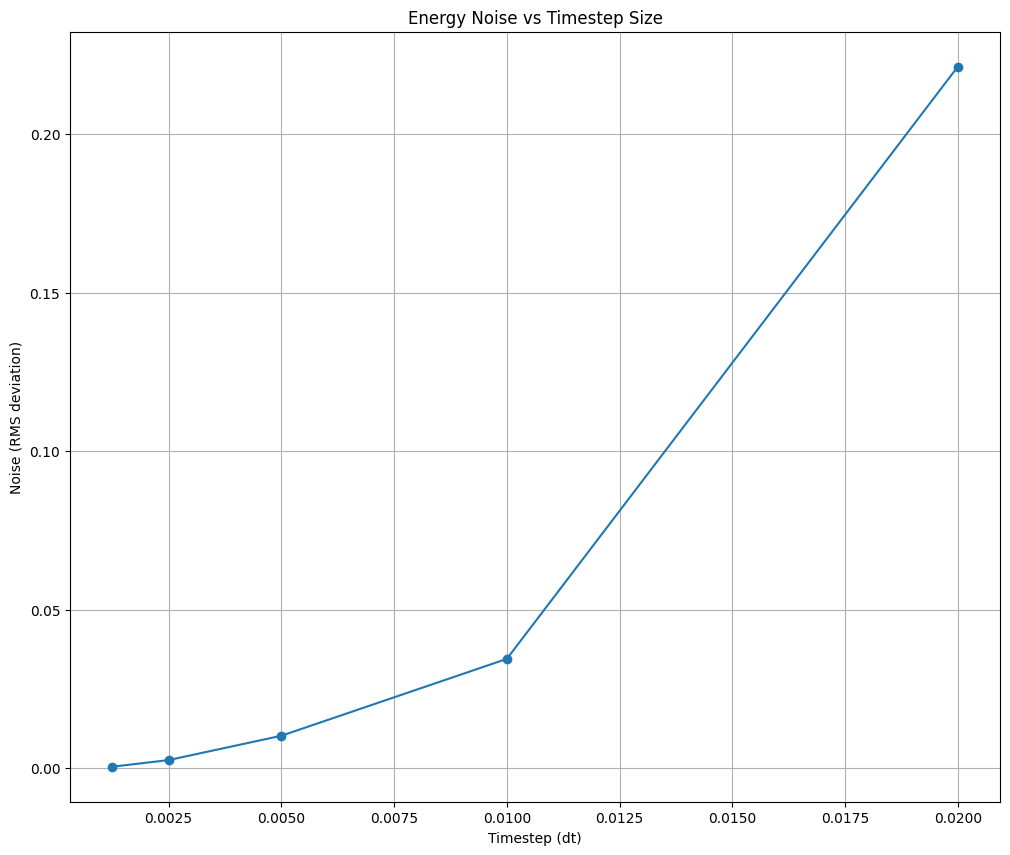

In [133]:
# Plot noise vs timestep
plt.figure(figsize=(12, 10))
plt.plot(dts, noise_values, 'o-')
plt.xlabel('Timestep (dt)')
plt.ylabel('Noise (RMS deviation)')
plt.title('Energy Noise vs Timestep Size')
plt.grid(True)

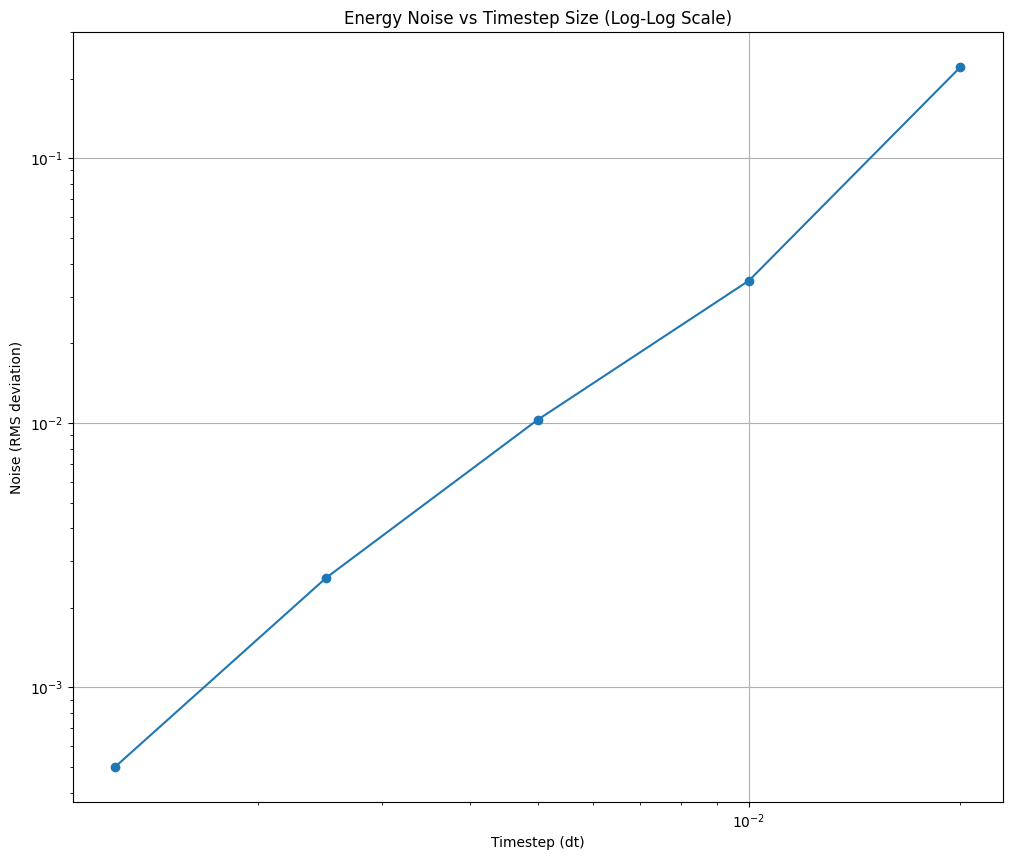

In [134]:
# Plot noise vs timestep (log-log scale)
plt.figure(figsize=(12, 10))
plt.loglog(dts, noise_values, 'o-')
plt.xlabel('Timestep (dt)')
plt.ylabel('Noise (RMS deviation)')
plt.title('Energy Noise vs Timestep Size (Log-Log Scale)')
plt.grid(True)

+---------------+------------------------+-----------------------+
| Timestep (dt) |         Drift          |         Noise         |
+---------------+------------------------+-----------------------+
|      0.02     |  0.05009776987910674   |   0.2212367995453853  |
|      0.01     |  0.014617949728492213  |    0.0344994127248    |
|     0.005     |  0.004826034379749002  |  0.01026894952523115  |
|     0.0025    | 0.0005279399965810937  |  0.002598026412962036 |
|    0.00125    | 0.00016235364343088464 | 0.0004997691192935012 |
+---------------+------------------------+-----------------------+


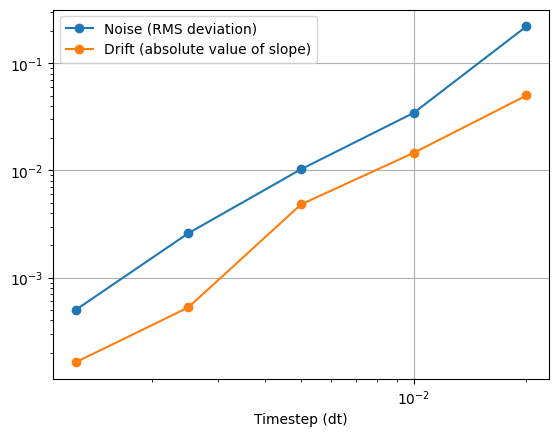

In [137]:
from prettytable import PrettyTable

# Add a reference line for second-order convergence
ref_x = np.array([min(dts), max(dts)])
ref_y = noise_values[-1] * (ref_x / dts[-1])**2

# Create a PrettyTable instance
table = PrettyTable()
table.field_names = ["Timestep (dt)", "Drift", "Noise"]

# Add rows to the table
for dt, drift, noise in zip(dts, drift_values, noise_values):
    table.add_row([dt, drift, noise])

# Print the table
print(table)

plt.loglog(dts, noise_values, 'o-', label='Noise (RMS deviation)')
plt.loglog(dts, drift_values, 'o-', label='Drift (absolute value of slope)')
plt.xlabel('Timestep (dt)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Problem 8.5 (c) – Conservation of linear momentum

num_steps = 10000
dt = 0.01

# Create the first simulation (without momentum reset)
sim1 = LJParticles(N=64, L=10.0, temperature=1.0, dt=dt)
sim1.compute_acceleration()
sim1.compute_energy()
initial_energy1 = sim1.total_energy

momentum_drift = []

for i in range(num_steps):
    sim1.step()

    if i % 10 == 0:
        px = np.sum(sim1.vx)
        py = np.sum(sim1.vy)
        total_p = np.sqrt(px**2 + py**2)
        momentum_drift.append(total_p)

# Create the second simulation (with momentum reset)
sim2 = LJParticles(N=64, L=10.0, temperature=1.0, dt=dt)
sim2.compute_acceleration()
sim2.compute_energy()
initial_energy2 = sim2.total_energy

momentum_drift_with_reset = []

for i in range(num_steps):
    sim2.step()

    if i % 10 == 0:
        px = np.sum(sim2.vx)
        py = np.sum(sim2.vy)
        total_p = np.sqrt(px**2 + py**2)
        momentum_drift_with_reset.append(total_p)

    if i % 1000 == 0:
        sim2.remove_drift()


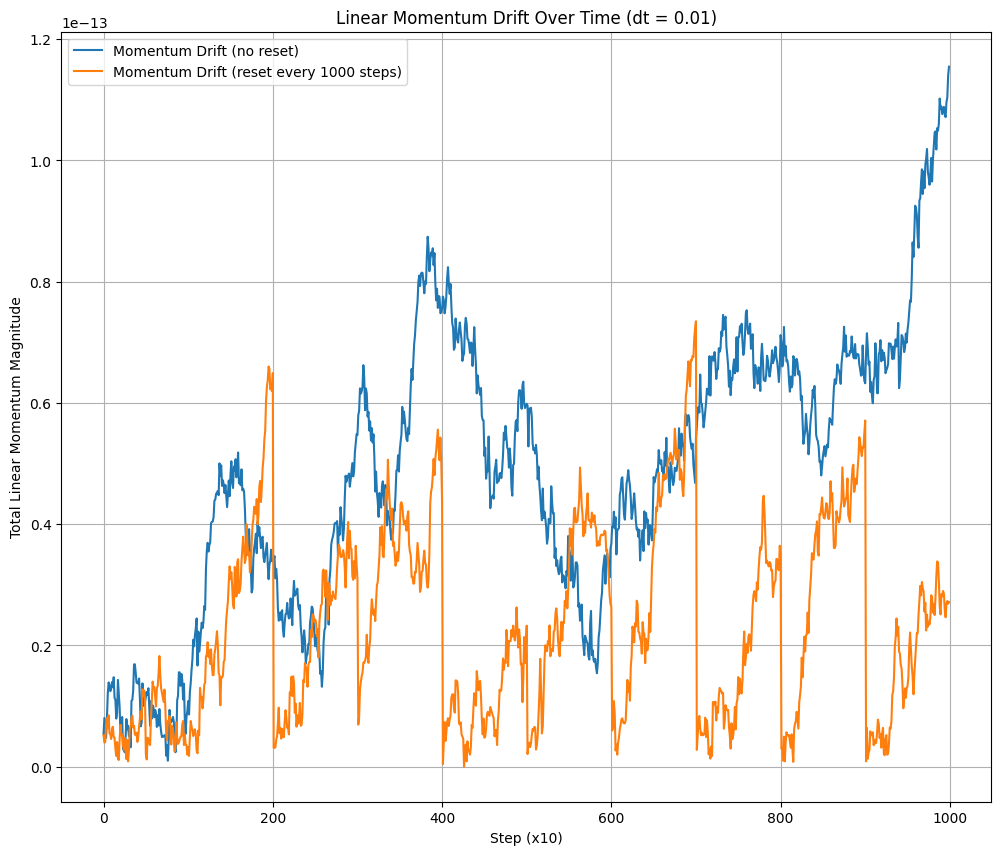

In [108]:
plt.figure(figsize=(12, 10))
plt.plot(momentum_drift, label='Momentum Drift (no reset)')
plt.plot(momentum_drift_with_reset, label='Momentum Drift (reset every 1000 steps)')
plt.xlabel("Step (x10)")
plt.ylabel("Total Linear Momentum Magnitude")
plt.title("Linear Momentum Drift Over Time (dt = 0.01)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Problem 8.7 (b) – PV/NkT ratio

sim = LJParticles(N=64, L=10.0, temperature=1.0, dt=0.0025)
sim.compute_acceleration()
sim.compute_energy()

num_steps = 5000
skip_steps = 1000
pressure_accum = 0
temperature_accum = 0

for step in range(num_steps):
    sim.step()

    # Skip some first steps to allow the system to equilibrate
    if step > skip_steps:
        # Accumulate pressure and temperature
        pressure_accum += sim.pressure
        temperature_accum += sim.get_temperature()

# Averages
P_avg = pressure_accum / (num_steps - skip_steps)
T_avg = temperature_accum / (num_steps - skip_steps)
V = sim.L ** 2
N = sim.N
# Calculate the ratio = P * V / (N * T)
ratio = P_avg * V / (N * T_avg)

print(f"Average T = {T_avg:.4f}")
print(f"Average P = {P_avg:.4f}")
print(f"PV/NkT = {ratio:.4f}")

Average T = 0.8998
Average P = 0.8702
PV/NkT = 1.5112
